# Support Vector Machines (SVM)

Since the logistic regression lab we have been developing more and more complex discriminative classifiers (i.e. without modelling the densities). In the previous lab, you have implemented the Perceptron algorithm, which is simple, but has several drawbacks.
The first drawback is that it finds just *some* separating hyperplane (decision boundary), but ideally we would like to find the *optimal* separating hyperplane (at least in some sense).
Another important drawback is, that Perceptron cannot deal with noisy/non-separable data. 


## SVM task

In this lab, we will continue examining the discriminative approach by implementing the Support Vector Machine (SVM) classifier, which handles both of these drawbacks.
Given an annotated training data set
$$
\mathcal{T} = \{ (\mathbf{x}_i, y_i)\}_{i = 1}^{m} \quad,\ \text{where} \ \mathbf{x}_i \in \mathbb{R}^n,\ y_i \in \{-1, 1\}
$$
the SVM **primal task** is formulated as

\begin{align}
 \mathbf{w^*}, b^*, \xi_i^* = \arg\min\limits_{\mathbf{w}, b, \xi_i} & \left( \frac{1}{2} \| \mathbf{w} \|^2 + C \sum_{i=1}^{m}{\xi_i} \right) \\
 \text{s.t. } & \langle\mathbf{w}, \mathbf{x}_i\rangle + b \ge +1 - \xi_i, \quad \text{for } y_i = +1, \\
 & \langle\mathbf{w}, \mathbf{x}_i\rangle + b \le -1 + \xi_i, \quad \text{for } y_i = -1, \\
 & \xi_i \ge 0,\ \forall i.
\end{align}

Here, and in the following text, $\langle\mathbf{a}, \mathbf{b}\rangle$ denotes dot product $\mathbf{a}^\top \mathbf{b}$.

The first term in the above optimisation task **maximises** the **margin**, $2/||\mathbf{w}||$, by minimising $||\mathbf{w}||$.
In the separable case, the margin is the distance between the separating hyperplane and the closest training point (intuitively, the further is the separating hyperplane from the training data, the better the classifier generalises to unseen data).
Thus the SVMs are sometimes referred to as Maximum margin classifier.
More detailed explanation can be found in [Section 3 of SVM tutorial](https://cw.fel.cvut.cz/wiki/lib/exe/fetch.php?tok=ce61b3&media=http%3A%2F%2Fcmp.felk.cvut.cz%2Fcmp%2Fcourses%2Frecognition%2FLabs%2Fsvm%2FSVM_tutorial-Burges98.pdf).

The sum in the minimisation task is over so called **slack variables**, $\xi_i$.
They allow some training points to be closer than the margin, or even on the incorrect side from the separating hyperplane (incorrectly classified).
Relaxing the constraints is counterbalanced by "paying" a user specified constant $C$ for any slack used.
This enables SVM to deal with linearly non-separable training data due to overlapping class data distributions or noisy training labels.
Compare the optimisation constraints with the one in Perceptron to see how it works.


### Interactive demo

The best way to really understand the SVM primal task is a hands-on demo.
Open [the demo](https://cw.fel.cvut.cz/wiki/courses/be5b33rpz/labs/08_svm/demo) and try to manually get the SVM cost function as low as possible, while respecting the constraints.
Start by changing the hyper-plane parameters $w_1$, $w_2$ and $b$ and slack variables.
Observe how the parameters relate to the displayed classifier.
You can also try to add more training samples and experiment with various data distribution shapes.


## SVM task in dual form

The primal SVM formulation is intuitive, but difficult to optimize.
Because of this, SVM are usually trained by solving the **dual form** derived from the primal form using Lagrange multipliers (see the lecture).

The dual form is given as

\begin{align}
\mathbf{\alpha^*} = \arg\max\limits_{\mathbf{\alpha}} & \left( \sum_{i=1}^{m} \alpha_i - \frac{1}{2} \sum_{i=1}^{m}\sum_{j=1}^{m}\alpha_i  y_i  k(\mathbf{x}_i, \mathbf{x}_j) y_j \alpha_j \right) \\
\text{s.t. } & C \ge \alpha_i \ge 0,\quad \text{for } i = 1, \dots, m \\
 & \sum_{i=1}^{m} \alpha_i y_i = 0
\end{align}

This is an example of a [quadratic programming](https://en.wikipedia.org/wiki/Quadratic_programming) problem, for which there are efficient solvers.
After the solver outputs the optimal vector of parameters $\mathbf{\alpha^*}$, a new data point $\mathbf{x'}$ is classified as

\begin{align}
h(\mathbf{x}'; \mathbf{\alpha^*}, b^*) & = \text{sign}\left(\sum_{i=1}^{m} \alpha^*_i y_i k(\mathbf{x'}, \mathbf{x}_i) + b^*\right).
\end{align}

Note that in the above summation, only the training samples where $\alpha_i > 0$ affect the classification. These training samples are called the **support vectors**, hence the name *Support Vector Machine*.
The calculation of the bias term $b^*$ needed for the classification goes beyond the scope of this lab, and therefore we provide a function `compute_bias` in the assignment template. Students who are more deeply interested in this problem are kindly referred to [libSVM paper (Section 4.1.5)](https://www.csie.ntu.edu.tw/~cjlin/papers/libsvm.pdf) or an "easy to follow" [explanation (exercise 4 solution)](http://fouryears.eu/wp-content/uploads/svm_solutions.pdf).


## Kernel function

In the dual form of the SVM task as well as in the classification function all the data $x_i$ appear **inside a dot product**.
We use the so called **kernel trick** by replacing all these dot products with evaluation of a kernel function $k: \mathbb{R}^n \times \mathbb{R}^n \mapsto \mathbb{R}$ which allows us to combine the dot product with a dimensionality lifting.
This way SVM can work with linearly non-separable data.
Given a fixed **feature space mapping** $\phi(\mathbf{x})$, the kernel function is defined as follows 
$$ k(\mathbf{x}, \mathbf{x}') = \langle\phi(\mathbf{x}), \phi(\mathbf{x}')\rangle $$
Functions that cannot be written this way are not kernels. 

The biggest advantage of using the kernel is that **we do not have to compute the dimensionality lifting** $\phi(\mathbf{x})$ explicitly, which can save a lot of computations.
This way we can also represent even infinite-dimensional lifting spaces.
This is, quite surprisingly, in fact useful as you will see!

When programming the SVM, we will pre-compute the $k(\mathbf{x}, \mathbf{x}')$ for all pairs of inputs and store them in a matrix using the `get_kernel` function that you should implement.

The function takes two matrices, `Xi` and `Xj` with the features stored in columns, like in this 2D example:


In [164]:
%load_ext autoreload
%autoreload 2
from svm import *
import numpy as np
from numpy import testing
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
Xi = np.array([[0, 1],
               [1, -1]])
Xj = np.array([[2, 1.5, -1.1],
               [-1, 0,  3]])

### Linear kernel

The simplest kernel is obtained when $\phi(\mathbf{x})$ is the identity mapping $\phi(\mathbf{x}) = \mathbf{x}$ resulting in the linear kernel
$$ k_L(\mathbf{x}, \mathbf{x}') = \langle\mathbf{x}, \mathbf{x}'\rangle$$


In [166]:
K = get_kernel(Xi, Xj, {'kernel': 'linear'})
print(K)
testing.assert_allclose(K, [[-1., 0., 3.],
                            [3., 1.5, -4.1]],
                        err_msg='The kernel values incorrect.')

[[-1.   0.   3. ]
 [ 3.   1.5 -4.1]]


For example the bottom-right value `-4.1` value is computed by taking the dot-product between the last column of `Xi` \[ 1, -1\]
 and the last column of `Xj` \[-1.1, 3.0\].

### Polynomial kernel

Another commonly used kernel, the polynomial kernel is defined as
$$ k_P(\mathbf{x}, \mathbf{x}') = (1 + \langle\mathbf{x}, \mathbf{x}'\rangle)^d$$
with some fixed $d \in \mathbb{R}$

In [167]:
K = get_kernel(Xi, Xj, {'kernel': 'polynomial', 'd': 2})
testing.assert_allclose(K, [[0., 1., 16.],
                            [16., 6.25, 9.61]],
                        err_msg='The kernel values incorrect.')

In [168]:
K = get_kernel(Xi, Xj, {'kernel': 'polynomial', 'd': 5})
with np.printoptions(precision=4, suppress=True):
    print(K)
testing.assert_allclose(K, [[0., 1., 1024.],
                            [1024., 97.6562, -286.2915]],
                        err_msg='The kernel values incorrect.', atol=1e-4)

[[   0.        1.     1024.    ]
 [1024.       97.6562 -286.2915]]


How many dimensions would the dimensional lifting corresponding to the polynomial kernel with $d=5$ have?  It is much more than five!

### RBF kernel

The most interesting kernel we will use is called Radial Basis Function (RBF) kernel defined as follows
$$ k_{\text{RBF}}(\mathbf{x}, \mathbf{x}') = e^{ \frac{ - \| \mathbf{x} - \mathbf{x}' \|^2_{2} }{2\sigma^2} } $$
Using the infinite series definition of the exponential function $e^x$, this expression can be manipulated into the "dot-product of lifted features" form, although the dimensional lifting is &infin;-dimensional this time!
You should be asking yourself: How could a classifier using such a lifting ever generalize? Wouldn't it overfit completely?
You can see for yourself in this nice [interactive SVM demo](https://cs.stanford.edu/people/karpathy/svmjs/demo/), try to change the parameter C and the RBF kernel sigma to see how they influence the result.

In [169]:
K = get_kernel(Xi, Xj, {'kernel': 'rbf', 'sigma': 1.0})
testing.assert_allclose(K, [[0.0183, 0.1969, 0.0739],
                            [0.6065, 0.5353, 0]],
                        err_msg='The kernel values incorrect.', atol=1e-4)

## SVM implementation

We will use a quadratic programming (QP) solver to optimize the SVM dual task.
The solver we will use accepts the task in an equivalent matrix form:

\begin{align}
\mathbf{\alpha^*} = \arg\max\limits_{\mathbf{\alpha}} & \left( \langle\mathbf{\alpha}, \mathbf{1}\rangle - \frac{1}{2} \mathbf{\alpha}^\top \mathbf{H} \mathbf{\alpha} \right) \\
\text{s.t. } & \langle\mathbf{\alpha}, \mathbf{y}\rangle = 0, \\
  & \mathbf{0} \le \mathbf{\alpha} \le \mathbf{C}
\end{align}

Your task is to implement the `svm(X, y, C, options)` function, which transforms the input data into the QP task definition (matrices and vectors) and passes it to the GSMO quadratic programming optimizer provided in the template.
Carefully read the docstring of the `gsmo` function and map the `svm` inputs `X, y, C, ...` into appropriate `gsmo` inputs `H, f, a, b, ...`.
Then use the optimized $\mathbf{\alpha}^*$ to extract the support vectors into `model['sv']` and the corresponding labels and lagrange multipliers into `model['y']` and `model['alpha']` respectively.
For numerical stability, compare $\alpha_i$ to $10^{-10}$ instead of $0$ when extracting the support vectors.
As mentioned above, the computation of the bias term $b$ is a bit involved, so use the `compute_bias` function already implemented in the template.


In [170]:
X = np.array([[1, 2, 1, -1, -1, -2],
              [1, 1, 2, -1, -2, -1]])
y = np.array([-1, 1, 1, 1, -1, -1])
C = 0.1
options = {'verb': True, 
           't_max': float('inf'),
           'kernel': 'linear'}

model = svm(X, y, C, options)

testing.assert_allclose(model['sv'], [[1, 2, 1, -1, -1, -2],
                                      [1, 1, 2, -1, -2, -1]],
                        err_msg='Support vectors incorrect.')
testing.assert_allclose(model['y'], [-1, 1, 1, 1, -1, -1], err_msg='Support vector labels incorrect.')
testing.assert_allclose(model['alpha'], [0.1, 0.1, 0.07777778, 0.1, 0.1, 0.07777778], err_msg='Alphas incorrect.')
testing.assert_allclose(model['b'], 0.0, err_msg='Bias incorrect.')

t=1, KKTviol=2.000000, tau=0.100000, tau_lb=0.000000, tau_ub=0.100000, Q_P=-0.195000
t=2, KKTviol=2.000000, tau=0.100000, tau_lb=0.000000, tau_ub=0.100000, Q_P=-0.390000
t=3, KKTviol=1.400000, tau=0.077778, tau_lb=0.000000, tau_ub=0.100000, Q_P=-0.444444


Implement the `classif_svm` function that applies a trained SVM model to input data `X`.

In [171]:
classif = classif_svm(X, model)
testing.assert_allclose(classif, [1, 1, 1, -1, -1, -1], err_msg='Classification incorrect.')

The following code visualizes the training data and the classifier.
The separating hyperplane is shown in red, the margin is darker and delimited by dashed lines.
The support vectors are marked by black circles.

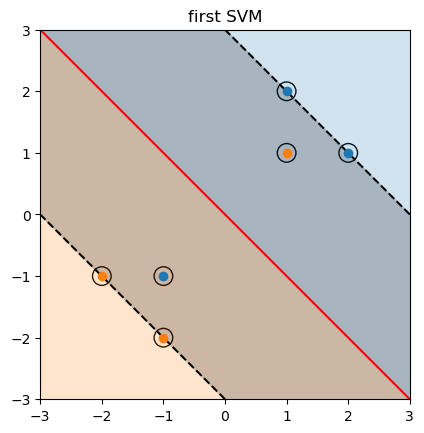

In [172]:
plt.gca().set_aspect("equal")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plot_boundary(plt.gca(), model)
plot_points(X, y)
plt.title('first SVM')
plt.savefig('first_svm.png', dpi=300)

All the training data are support vectors, but hopefully this won't be the case when we add more data.
Let's load a slightly bigger toy dataset.

In [173]:
data = np.load("data_svm1.npz", allow_pickle=True)
X_toy = data["X"]
y_toy = data["y"]

### Hard-margin vs soft-margin SVM

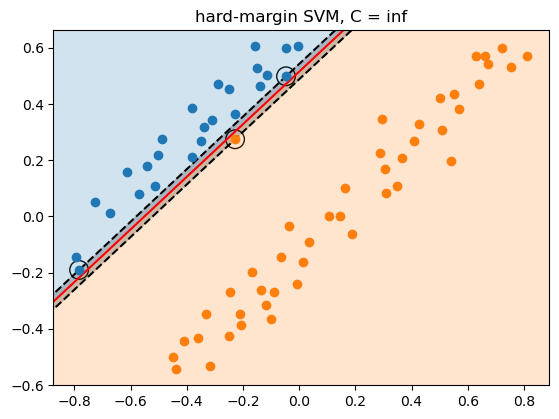

In [174]:
C = np.inf
options = {'verb': False, 
           't_max': float('inf'),
           'kernel': 'linear'}
model = svm(X_toy, y_toy, C, options=options)
plot_points(X_toy, y_toy)
plot_boundary(plt.gca(), model)
plt.gca().set_aspect("equal")
plt.title('hard-margin SVM, C = {}'.format(C))
plt.savefig('linear_svm_hard_margin.png', dpi=300)

As you can see, the toy data are linearly separable and the classifier needs only 3 support vectors.
We have set $C = \infty$ to effectively disable slack variables, creating a *hard-margin* SVM which has zero training-set error.

Unfortunately, this classifier will probably not generalize well, i.e. it is quite likely that a testing point newly sampled from the blue class will "cross the line" and will be classified incorrectly.
This issue is caused by a single training sample from the orange class - maybe the annotator of the ground-truth dataset made an error.

Now look what happens when we enable slack variables by setting $C = 1$ and train a *soft-margin* SVM.

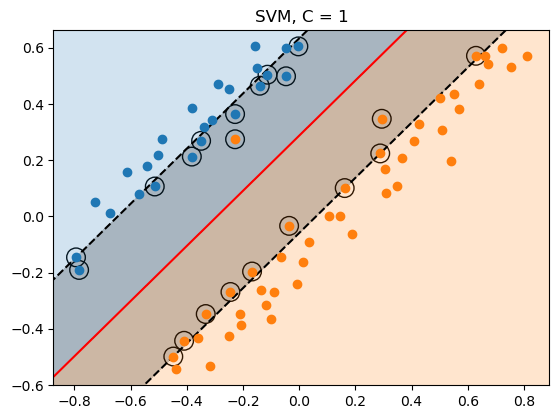

In [175]:
C = 1
options = {'verb': False, 
           't_max': float('inf'),
           'kernel': 'linear'}
model = svm(X_toy, y_toy, C, options=options)
plot_points(X_toy, y_toy)
plot_boundary(plt.gca(), model)
plt.gca().set_aspect("equal")
plt.title('SVM, C = {}'.format(C))
plt.savefig('linear_svm.png', dpi=300)

You can interactively change the $C$ parameter in the following code (assuming you have `ipywidgets` installed).

In [176]:
try:
    from ipywidgets import interact, interactive, fixed

    @interact(C=(0.001,100.,0.001))
    def soft_margin(C=1):
        model = svm(X_toy, y_toy, C, options={'verb': False,
                                              't_max': float('inf'),
                                              'kernel': 'linear'})
        plt.gca().set_aspect("equal")
        plot_points(X_toy, y_toy)
        plot_boundary(plt.gca(), model)
        plt.title('Soft-margin SVM, C = {}'.format(C));

except ImportError:
    print('Optional feature.')

interactive(children=(FloatSlider(value=1.0, description='C', min=0.001, step=0.001), Output()), _dom_classes=…

### Kernel SVM

Now we will experiment with dimensionality lifting using the kernel trick.
Let's first load some linearly non-separable data and train a linear SVM.

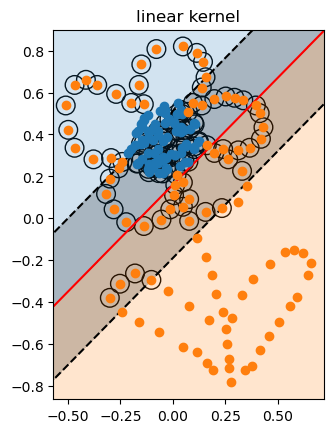

In [177]:
data = np.load("flower.npz", allow_pickle=True)
X_flower = data["X"]
y_flower = data["y"]
C = 10

options = {'verb': False, 
           't_max': float('inf'),
           'kernel': 'linear'}

model = svm(X_flower, y_flower, C, options)

plot_points(X_flower, y_flower)
plot_boundary(plt.gca(), model)
plt.title('linear kernel')
plt.gca().set_aspect("equal")
plt.savefig('flower_linear.png', dpi=300)

This does not work very well.
In this case looking at the image is enough to tell that the classifier is bad.
For more complicated, higher-dimensional data you would have to look at training and validation error, or the number of support vectors instead.

The RBF and the polynomial kernels work much better:

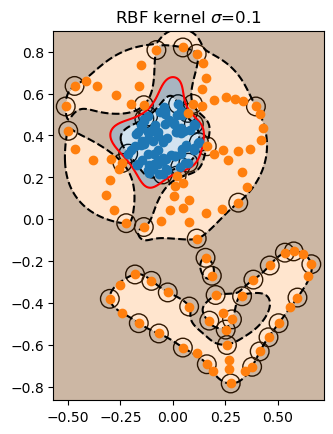

In [178]:
sigma = 0.1
options = {'verb': False, 
           't_max': float('inf'),
           'kernel': 'rbf', 
           'sigma': sigma}

model = svm(X_flower, y_flower, C, options)

plot_points(X_flower, y_flower)
plot_boundary(plt.gca(), model)
plt.title('RBF kernel $\sigma$={}'.format(sigma))
plt.gca().set_aspect("equal")
plt.savefig('flower_rbf.png', dpi=300)

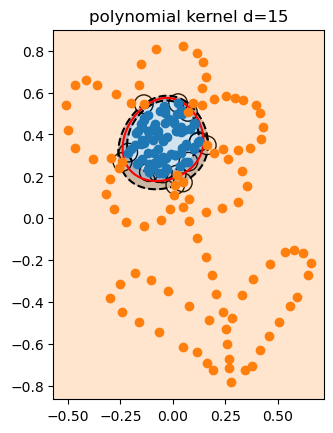

In [179]:
d = 15
options = {'verb': False, 
           't_max': float('inf'),
           'kernel': 'polynomial', 
           'd': d}

model = svm(X_flower, y_flower, C, options)

plot_points(X_flower, y_flower)
plot_boundary(plt.gca(), model)
plt.title('polynomial kernel d={}'.format(d))
plt.gca().set_aspect("equal")
plt.savefig('flower_polynomial.png', dpi=300)

## SVM for letter classification

Now we will train a SVM to classify letters as in the previous assignments.


### Feature normalization

We will use two-dimensional features (left-right and up-down as before), but this time we will also **normalize the measurements to have zero mean and unit standard deviation**.
This is a common pre-processing technique that greatly helps the SVM optimizer, but is also useful for other machine learning methods.
Implement `compute_measurements_2d` function that computes the left-right features ((sum of pixel intensities in the left half of the image i) - (sum of pixel intensities in the right half of the image i)) and the up-down features ((sum of pixel intensities in the top half of the image i) - (sum of pixel intensities in the bottom half of the image i)).
Both the left-right and the up-down features should then be independently normalized, using the normalization parameters either provided on input, or computed from the data.

The function returns the normalization parameters so that they can be reused to normalize test set features later as in this toy example:

In [180]:
trn_data = {'images': np.array(
    [[[5, 0],
      [3, 0]],
     [[10, 8],
      [0, 0]]]).transpose(1, 2, 0),  # NxHxW -> HxWxN
            'labels': np.array([1, -1])
            }
X_trn, y_trn, norm_trn = compute_measurements_2d(trn_data)
np.testing.assert_array_almost_equal(X_trn, np.array([[1, -1],
                                                      [-1, 1]]))
np.testing.assert_array_almost_equal(y_trn, np.array([1, -1]))
np.testing.assert_almost_equal(norm_trn['lr_mean'], 5.0)
np.testing.assert_almost_equal(norm_trn['lr_std'], 3.0)
np.testing.assert_almost_equal(norm_trn['ud_mean'], 10.0)
np.testing.assert_almost_equal(norm_trn['ud_std'], 8.0)

tst_data = {'images': np.array(
    [[[5, 0],
      [3, 0]]]).transpose(1, 2, 0),  # NxHxW -> HxWxN
            'labels': np.array([1])}
X_tst, y_tst, _ = compute_measurements_2d(tst_data, norm_trn)
np.testing.assert_array_almost_equal(X_tst[:, 0], X_trn[:, 0])

Let's now load the real dataset and compute the measurements.
**Make sure your feature computation and normalization does not overflow** (The images are stored in 8-bit unsigned integers, only allowing values between 0 and 255).

In [181]:
data = np.load("data_svm1_images.npz", allow_pickle=True)
trn_data = data["trn"].item()
tst_data = data["tst"].item()

X_trn, y_trn, norm_trn = compute_measurements_2d(trn_data)
X_tst, y_tst, _ = compute_measurements_2d(tst_data, norm_trn)

### Hyper-parameter selection

We will use cross-validation to select optimal SVM hyper-parameters.
We have seen three hyper-parameters: $C$, kernel type and kernel hyper-parameter ($\sigma$ for RBF, $d$ for polynomial kernel).
To simplify the problem, we will now consider only the polynomial kernel and search for the best values of $C$ and $d$.

We will split the training dataset with 4-fold cross-validation.

In [182]:
np.random.seed(42)
trn_folds, tst_folds = crossval(y_trn.size, num_folds=4)

Now implement the `svm_crossvalidation` function and search over some fixed hyperparameter values (this will probably take some time).

In [183]:
Cs = [0.001, 0.1, 1, 10]
ds = [1, 3, 5]

best_params = None
best_err = np.inf
for C in Cs:
    for d in ds:
        options = {'verb': False, 't_max': 100000,
                   'kernel': 'polynomial', 'd': d}
        err = svm_crossvalidation(trn_folds, tst_folds, X_trn, y_trn, C, options)

        if err < best_err:
            best_err = err
            best_params = (C, d)
        print('C {}, d {} -> err {}'.format(C, d, err))

C 0.001, d 1 -> err 0.0901388888888889
C 0.001, d 3 -> err 0.09680555555555556
C 0.001, d 5 -> err 0.08736111111111111
C 0.1, d 1 -> err 0.07319444444444445
C 0.1, d 3 -> err 0.07402777777777778
C 0.1, d 5 -> err 0.09125
C 1, d 1 -> err 0.07319444444444445
C 1, d 3 -> err 0.07541666666666666
C 1, d 5 -> err 0.25777777777777783
C 10, d 1 -> err 0.07388888888888889
C 10, d 3 -> err 0.3115277777777778
C 10, d 5 -> err 0.3563888888888889


In [184]:
print('best params: C={}, d={}'.format(best_params[0], best_params[1]))

best params: C=0.1, d=1


Now that we know the best hyperparameters, we will re-train the SVM on the whole training dataset.

In [185]:
C = best_params[0]
d = best_params[1]

options = {'verb': False, 
           't_max': float('inf'),
           'kernel': 'polynomial', 
           'd': d}
model = svm(X_trn, y_trn, C, options)

Let's now visualize the results.

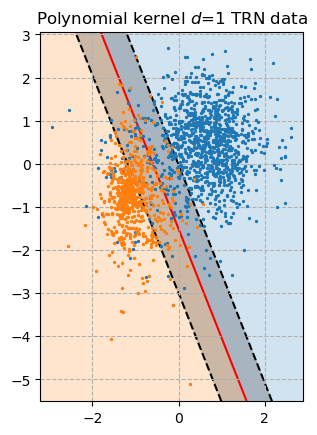

In [186]:
plot_points(X_trn, y_trn, size=2)
plot_boundary(plt.gca(), model, plot_support_vectors=False)
plt.gca().set_aspect("equal")
plt.grid(linestyle='--')
plt.title('Polynomial kernel $d$={} TRN data'.format(d))
plt.savefig('ocr_polynomial_kernel_trn.png', dpi=300)

test set error: 0.045


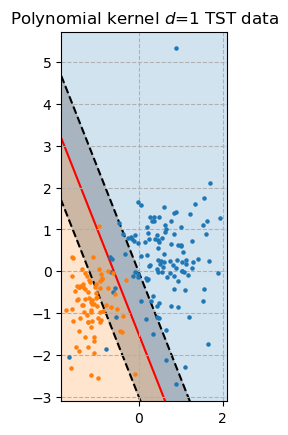

In [187]:
classif = classif_svm(X_tst, model)

err = np.mean(classif != y_tst)
print(f'test set error: {err}')

plt.gca().set_aspect("equal")
plot_points(X_tst, y_tst, size=5)
plt.gca().relim()
plt.grid(linestyle='--')
plt.title('Polynomial kernel $d$={} TST data'.format(d))
plot_boundary(plt.gca(), model, plot_support_vectors=False)
plt.savefig('ocr_polynomial_kernel_tst.png')

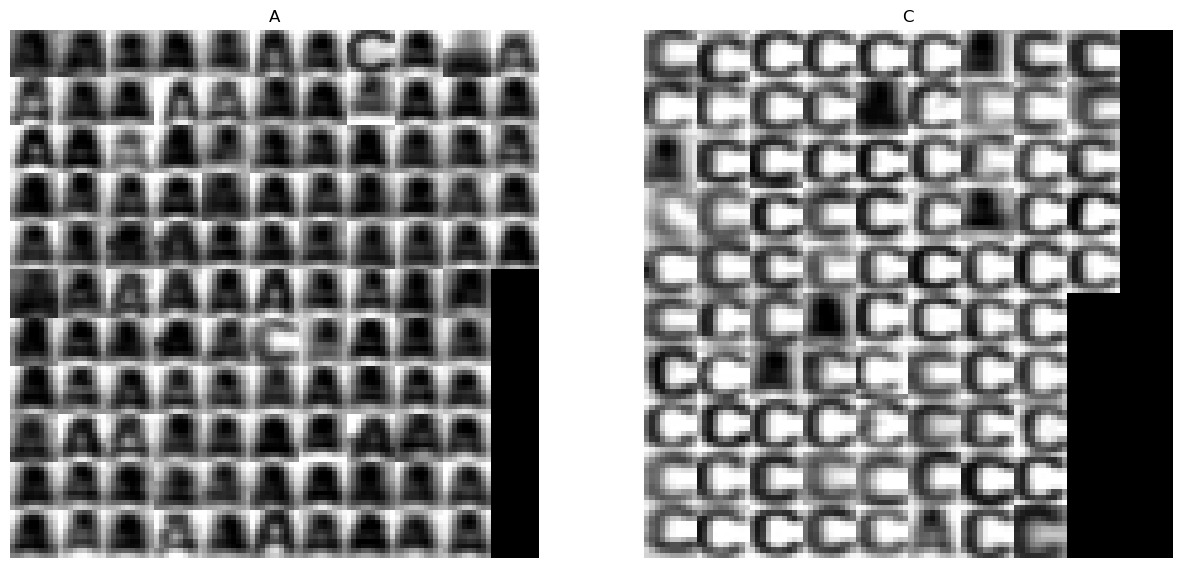

In [188]:
labels = classif.copy()
labels[labels == 1] = 0
labels[labels == -1] = 1

plt.figure(figsize=(15,10))
show_classification(tst_data['images'], labels, 'AC')
plt.savefig('ocr_svm_classif.png', dpi=300)

## SVM for MNIST digit classification

In this last part of the assignment, we will train SVM for classification of [MNIST](http://yann.lecun.com/exdb/mnist/) handwritten digits.
We will use the flattened $28 \times 28$ image intensities directly as $784$-dimensional features (we have already normalized the data).

In [189]:
data = np.load("mnist_trn.npz", allow_pickle=True)
X_trn = data['X']
y_trn = data['y']

data = np.load("mnist_tst.npz", allow_pickle=True)
X_tst = data['X']
y_tst = data['y']

Just like before, we will use crossvalidation to find the best hyperparameters.  This time with the RBF kernel.

In [190]:
np.random.seed(42)
trn_folds, tst_folds = crossval(y_trn.size, num_folds=5)
sigmas = [0.1, 1, 10, 20, 100, 1000]
Cs = [0.01, 0.1, 1, 10]

best_params = None
best_err = np.inf
for C in Cs:
    for sigma in sigmas:
        options = {'verb': False, 't_max': float('inf'),
                   'kernel': 'rbf', 'sigma': sigma}
        err = svm_crossvalidation(trn_folds, tst_folds, X_trn, y_trn, C, options)

        if err < best_err:
            best_err = err
            best_params = (C, sigma)
        print('C {}, sigma {} -> err {}'.format(C, sigma, err))

C 0.01, sigma 0.1 -> err 0.5
C 0.01, sigma 1 -> err 0.5
C 0.01, sigma 10 -> err 0.5
C 0.01, sigma 20 -> err 0.494
C 0.01, sigma 100 -> err 0.5
C 0.01, sigma 1000 -> err 0.5
C 0.1, sigma 0.1 -> err 0.5
C 0.1, sigma 1 -> err 0.5
C 0.1, sigma 10 -> err 0.012500000000000002
C 0.1, sigma 20 -> err 0.0025
C 0.1, sigma 100 -> err 0.309
C 0.1, sigma 1000 -> err 0.5
C 1, sigma 0.1 -> err 0.11199999999999999
C 1, sigma 1 -> err 0.11199999999999999
C 1, sigma 10 -> err 0.002
C 1, sigma 20 -> err 0.002
C 1, sigma 100 -> err 0.0025
C 1, sigma 1000 -> err 0.5
C 10, sigma 0.1 -> err 0.11199999999999999
C 10, sigma 1 -> err 0.11199999999999999
C 10, sigma 10 -> err 0.002
C 10, sigma 20 -> err 0.0005
C 10, sigma 100 -> err 0.0025
C 10, sigma 1000 -> err 0.20800000000000002


In [191]:
print('best params: C={}, sigma={}'.format(best_params[0], best_params[1]))

best params: C=10, sigma=20


And finally train on the whole training set.

In [192]:
C = best_params[0]
sigma = best_params[1]

options = {'verb': False, 't_max': float('inf'),
           'kernel': 'rbf', 'sigma': sigma}
model = svm(X_trn, y_trn, C, options)

The classifier should perform quite well:

test set error: 0.0028763183125599234


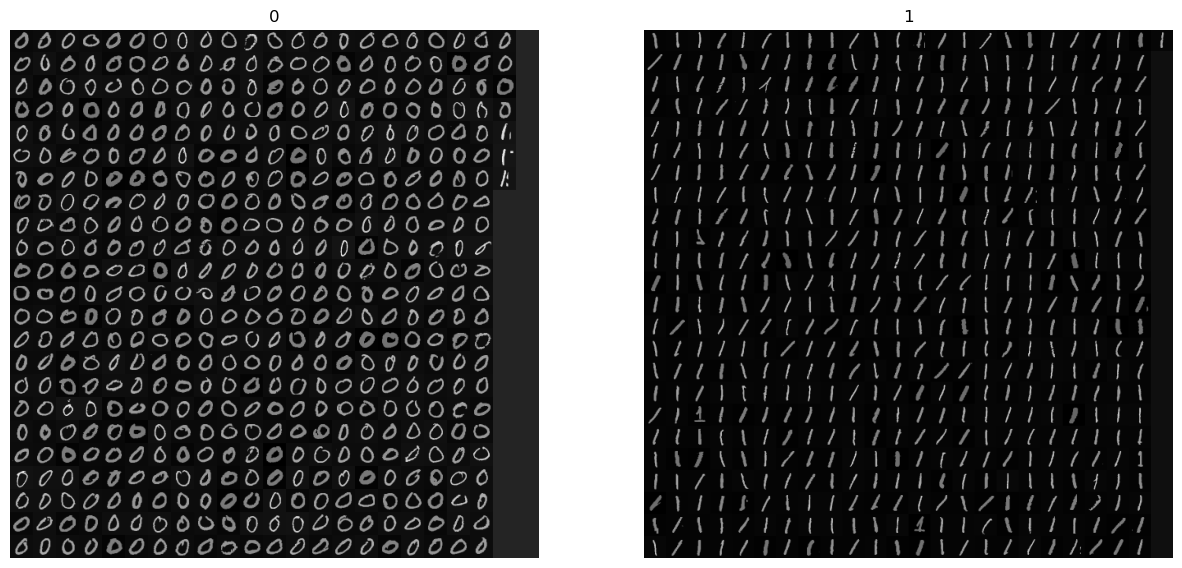

In [193]:
prediction = classif_svm(X_tst, model)
err = np.mean(prediction != y_tst)
print(f'test set error: {err}')

plt.figure(figsize=(15,10))
show_classification(X_tst.reshape(28,28,-1), prediction > 0, '01')
plt.savefig('mnist_tst_classif.png', dpi=300)

We can also visualize the support vectors.  These are the "hardest-to-classify" samples.

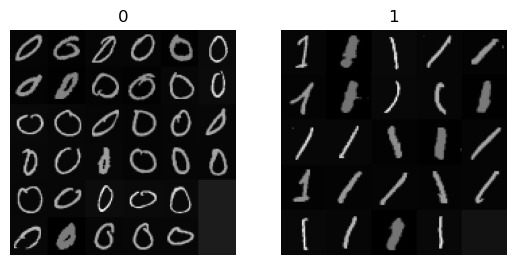

In [194]:
show_classification(model['sv'].reshape(28, 28, -1), model['y'] > 0, '01')
plt.savefig('mnist_support_vectors.png')

# Submission to the BRUTE Upload System
To fulfill this assignment, you need to submit these files (all packed in one `.zip` file) into the __[upload system](https://cw.felk.cvut.cz/brute/)__:
- `svm.ipynb` - a notebook for data initialisation, calling of the implemented functions and plotting of their results (for your convenience, will not be checked).
- `svm.py` - file with the following methods implemented:
    - `get_kernel`
    - `svm`
    - `classif_svm`
    - `svm_crossvalidation`
    - `compute_measurements_2d`

- `first_svm.png`, `linear_svm_hard_margin.png`, `linear_svm.png`, `flower_linear.png`, `flower_rbf.png`, `flower_polynomial.png`, `ocr_polynomial_kernel_trn.png`, `ocr_polynomial_kernel_tst.png`, `ocr_svm_classif.png`, `mnist_tst_classif.png`, `mnist_support_vectors.png`

When preparing a zip file for the upload system, do not include any directories, the files have to be in the zip file root.

# Bonus task

Try to combine several binary SVM classifiers into a multiclass one. Use the “one versus all” technique (see e.g. [this link](http://www.mit.edu/~9.520/spring09/Classes/multiclass.pdf) for the general idea).

Use [MNIST data](https://cw.fel.cvut.cz/wiki/_media/courses/be5b33rpz/labs/08_svm/mnist_trn_multiclass_bonus.zip) to create a multiclass classifier of images of numerals. The file contains 30 000 examples of normalized images of digits stored in matrix X
and corresponding labels (the label is the digit itself) $y \in \{0, 1, \dots, 9\}$. Use actual pixel values as features, in this case your feature space will be 784 dimensional.

Display the resulting classification (i.e. the montage of all images classified as $0,1,\dots,9$).

**Hint:** use some reasonable subset of data for training and testing, training with 30 000 examples would need extensive amounts of ram and would take too much time. Preserve proportions of classes when doing subsampling. 